In [1]:
# Imports
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.transforms.functional as tf
from torchvision.transforms import v2
import torch.optim as optim
from matplotlib import pyplot as plt
import pykinect_azure as azk
import numpy as np
from random import randrange
from ctypes import *
import torch.nn.functional as F

# Select device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize Kinect libraries
azk.initialize_libraries()

# Set plotting style
%matplotlib inline

In [127]:
# --------------------------------------------------------------------------------
# Takes in raw depth data and outputs 0.0-1.0 depth + normal map channels
# --------------------------------------------------------------------------------
def to_normal(depth):
  out = []

  for img in depth:
    smoothed = img.type(torch.float32).squeeze(0)
    y, x = torch.gradient(smoothed)

    normal = torch.dstack((-x, -y, torch.ones_like(smoothed)))

    n = torch.linalg.norm(normal, dim=2)

    normal[:, :, 0] /= n
    normal[:, :, 1] /= n
    normal[:, :, 2] /= n

    normal += 1
    normal /= 2

    d_out = smoothed.div(15_000.0).unsqueeze(0)
    n_out = normal.permute(2, 0, 1)

    img_out = torch.cat((d_out, n_out))

    out.append(img_out)
  
  return torch.stack(out)

In [3]:
# --------------------------------------------------------------------------------
# Load training data
# --------------------------------------------------------------------------------

pairs = []

# --------------------------------------------------
#                      OPEN
# --------------------------------------------------
print("OPEN")
path = "E:\\palm_reader\\recordings\\open.mkv"
pb = azk.start_playback(path)
while True:
    r, cap = pb.update()
    if not r:
        break
    r, d = cap.get_depth_image()
    if not r:
        break

    depth = torch.tensor(d.astype(int)).unsqueeze(0)
    x = to_normal(depth)
    x = F.avg_pool2d(x, (7, 7));
    pairs.append((x.squeeze(), 0.0))

# --------------------------------------------------
#                      FIST
# --------------------------------------------------
print("FIST")
path = "E:\\palm_reader\\recordings\\fist.mkv"
pb = azk.start_playback(path)
while True:
    r, cap = pb.update()
    if not r:
        break
    r, d = cap.get_depth_image()
    if not r:
        break

    depth = torch.tensor(d.astype(int)).unsqueeze(0)
    x = to_normal(depth)
    x = F.avg_pool2d(x, (7, 7));
    pairs.append((x.squeeze(), 0.0))

# --------------------------------------------------
#                      PEACE
# --------------------------------------------------
print("PEACE")
path = "E:\\palm_reader\\recordings\\peace.mkv"
pb = azk.start_playback(path)
while True:
    r, cap = pb.update()
    if not r:
        break
    r, d = cap.get_depth_image()
    if not r:
        break

    depth = torch.tensor(d.astype(int)).unsqueeze(0)
    x = to_normal(depth)
    x = F.avg_pool2d(x, (7, 7));
    pairs.append((x.squeeze(), 0.0))

# --------------------------------------------------
#                      POINT
# --------------------------------------------------
print("POINT")
path = "E:\\palm_reader\\recordings\\point.mkv"
pb = azk.start_playback(path)
while True:
    r, cap = pb.update()
    if not r:
        break
    r, d = cap.get_depth_image()
    if not r:
        break

    depth = torch.tensor(d.astype(int)).unsqueeze(0)
    x = to_normal(depth)
    x = F.avg_pool2d(x, (7, 7));
    pairs.append((x.squeeze(), 0.0))

# --------------------------------------------------
#                      HANG TEN
# --------------------------------------------------
print("HANG TEN")
path = "E:\\palm_reader\\recordings\\hang_ten.mkv"
pb = azk.start_playback(path)
while True:
    r, cap = pb.update()
    if not r:
        break
    r, d = cap.get_depth_image()
    if not r:
        break

    depth = torch.tensor(d.astype(int)).unsqueeze(0)
    x = to_normal(depth)
    x = F.avg_pool2d(x, (7, 7));
    pairs.append((x.squeeze(), 1.0))

OPEN
FIST
PEACE
POINT
HANG TEN


1.0


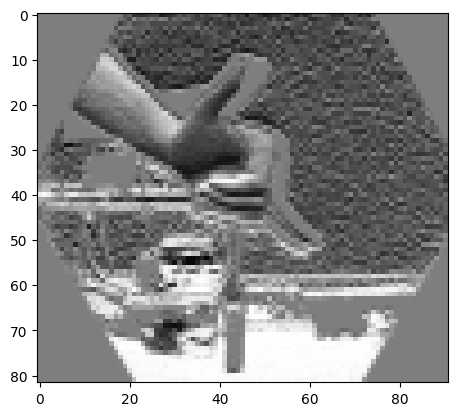

In [4]:
tup = pairs[24400]
img, label = tup

print(label)

plt.imshow(img[2].cpu(), cmap="gray")

In [5]:
# --------------------------------------------------------------------------------
# Dataset definition
# --------------------------------------------------------------------------------
class HandDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        v = self.data[idx]
        return self.transform(v[0]), torch.tensor(v[1])

torch.Size([256, 4, 82, 91])
tensor(0.1603)
tensor(0.)
tensor(0.)


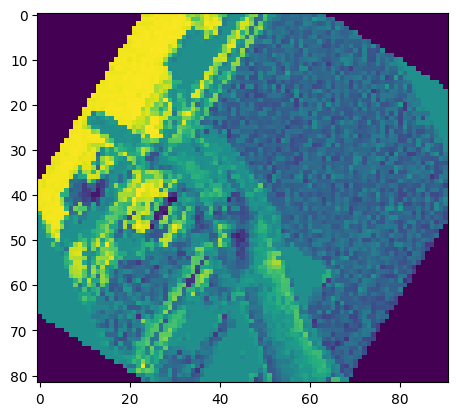

In [6]:

transforms = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomAffine(degrees=(-180, 180), translate=(0, .1), scale=(.9, 1.1))
])


hand_dataset = HandDataset(data=pairs, transform=transforms)


torch.set_printoptions(profile="full")

# --------------------------------------------------------------------------------
# Split training and test sets
# --------------------------------------------------------------------------------
percent_train = 0.8
train_size = int(0.8 * len(hand_dataset))
test_size = len(hand_dataset) - train_size

train_ds, test_ds = torch.utils.data.random_split(hand_dataset, [train_size, test_size])


# --------------------------------------------------------------------------------
# Initialize dataloaders
# --------------------------------------------------------------------------------
train_dl = DataLoader(train_ds, batch_size=256, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=256, shuffle=True)

dataiter = iter(test_dl)
batch, labels = next(dataiter)

# print images
i = 3
image = batch[0]
print(batch.shape)
print(image[0].max())
print(image[0].min())
print(labels[i])
plt.imshow(batch[0][2])

#OPEN
#FIST
#PEACE
#POINT
#BUFFALO


In [7]:
# --------------------------------------------------------------------------------
# Model definition
# --------------------------------------------------------------------------------
class TestModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.conv1 = nn.Conv2d(4, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3)

        self.pool1 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(9216, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 1)
        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()

    def forward(self, x):
        #print(x.shape)
        #print(x.device)
        #print("BEFORE CHECK")
        if x.size(dim=1) == 1: 
            #print("AFTER CHECK")
            x = to_normal(x.type(torch.float32))
            x = F.avg_pool2d(x, (7, 7))
            #print(x.shape)

        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool1(self.relu(self.conv2(x)))
        x = self.pool1(self.relu(self.conv3(x)))
        x = self.flatten(x)

        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sig(self.fc3(x))

        return x

model = TestModel().to(device)

In [10]:
loss_fn = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
checkpoint = 10

for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    total_preds = 0
    correct_preds = 0
    print(f"\n\n--- EPOCH {epoch+1} ----------------------------------------------")
    for i, data in enumerate(train_dl, 0):
        model.train()
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        #print("LABELS")
        #print(labels)
        #print("PREDICTIONS")
        #print(outputs.squeeze())
        loss = loss_fn(outputs.squeeze(), labels)
        #print("LOSS")
        #print(loss)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % checkpoint == checkpoint-1:
            print(f'{i + 1:5d}] loss: {running_loss / checkpoint:.3f}')
            running_loss = 0.0
            total_preds = 0
            correct_preds = 0
    
    crrect_guesses = 0
    test_loss = 0.0
    with torch.no_grad():
        model.eval()
        samples = 0
        for i, data in enumerate(test_dl, 0):
            samples += 1
            inputs, labels = data
            #print(inputs)
            #print(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            preds = model(inputs)
            torch.set_printoptions(precision=3, sci_mode=False)
            print(preds[:10])
            loss = loss_fn(preds.squeeze(1).to(device), labels.type(torch.float32).to(device))
            test_loss += loss.item()
        print("Avg Test Loss = ", test_loss/samples)
            

print('\nFinished Training')
torch.cuda.empty_cache()



--- EPOCH 1 ----------------------------------------------
   10] loss: 0.068
   20] loss: 0.077
   30] loss: 0.075
   40] loss: 0.062
   50] loss: 0.077
   60] loss: 0.063
   70] loss: 0.063
   80] loss: 0.071
tensor([[    0.978],
        [    1.000],
        [    0.995],
        [    0.009],
        [    0.002],
        [    0.000],
        [    0.002],
        [    0.000],
        [    0.000],
        [    0.015]], device='cuda:0')
tensor([[    0.001],
        [    0.040],
        [    0.119],
        [    0.000],
        [    0.003],
        [    0.949],
        [    0.169],
        [    0.001],
        [    0.041],
        [    0.968]], device='cuda:0')
tensor([[0.007],
        [0.101],
        [0.127],
        [0.969],
        [0.004],
        [0.001],
        [0.002],
        [0.998],
        [0.001],
        [0.990]], device='cuda:0')
tensor([[    0.985],
        [    0.000],
        [    0.450],
        [    1.000],
        [    0.823],
        [    0.046],
        [    0.00

In [ ]:
for name, param in model.named_parameters():
    print(name, param.grad.abs().sum())

# Save to Disk

In [11]:
path = "E:/palm_reader/src-tauri/src/models/hang_ten.pt"

#raise

torchscript_model = torch.jit.script(model)
torchscript_model.save(path)

# LOAD FROM DISK
#model = torch.jit.load('model_scripted.pt')
#model.eval()

# Ensemble Model

In [164]:
class EnsembleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.open_hand = torch.jit.load("E:/palm_reader/src-tauri/src/models/open.pt")
        self.fist = torch.jit.load("E:/palm_reader/src-tauri/src/models/fist.pt")
        self.peace = torch.jit.load("E:/palm_reader/src-tauri/src/models/peace.pt")
        self.point = torch.jit.load("E:/palm_reader/src-tauri/src/models/point.pt")
        self.hang_ten = torch.jit.load("E:/palm_reader/src-tauri/src/models/hang_ten.pt")

        self.open_hand.eval()
        self.fist.eval()
        self.peace.eval()
        self.point.eval()
        self.hang_ten.eval()


    def forward(self, x):
        if x.size(dim=0) == 1: 
            # For deployed model
            x = x.unsqueeze(0)
            x = to_normal(x.type(torch.float32))
            x = F.avg_pool2d(x, (7, 7))
            x.squeeze()
        else:
            # In notebook testing
            x = x.unsqueeze(0)

        preds = [
            self.open_hand(x).item(),
            self.fist(x).item(),
            self.peace(x).item(),
            self.point(x).item(),
            self.hang_ten(x).item(),
        ]

        return torch.cat((
            self.open_hand(x),
            self.fist(x),
            self.peace(x),
            self.point(x),
            self.hang_ten(x),)
        ).T
        

ensemble = EnsembleModel()

torch.Size([4, 82, 91])
THIS IS THE THING
cuda:0
Ok
0
tensor([[    0.002,     1.000,     0.000,     0.041,     0.002]],
       device='cuda:0', grad_fn=<PermuteBackward0>)


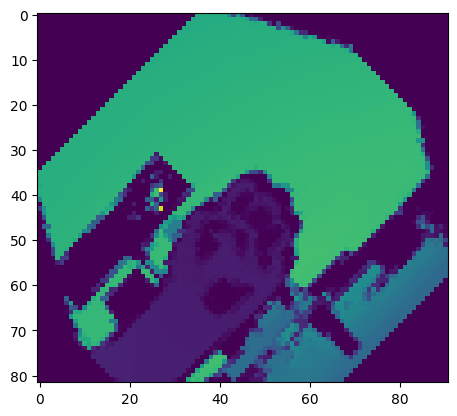

In [165]:
dataiter = iter(test_dl)
batch, labels = next(dataiter)

i = batch[3]

print(i.shape)

preds = ensemble(i.to(device))

plt.imshow(i[0])

print(preds)

In [166]:
ens_path = "E:/palm_reader/src-tauri/src/models/ensemble.pt"

ens_ts = torch.jit.script(ensemble)
ens_ts.save(ens_path)